# Dask Queue-based Progress Bar Demo

In [1]:
from qprogress import progress, compute_with_progress

In [2]:
from dask.distributed import Client, Queue
client = Client(n_workers=20, threads_per_worker=1)

Something to compute:

In [3]:
def some_fun(v, progress):
    progress.put(int(v))
    return v

def setup_computation():
    import numpy as np
    import dask.bag as db
    from dask.distributed import Queue
    
    vals = np.arange(3000)

    q1, q2 = Queue(), Queue()
    b = ( db
         .from_sequence(vals)
         .map(some_fun, progress=q1)
         .map(lambda x: [x, 2*x])
         .flatten()
         .map(some_fun, progress=q2)
        )
    
    return b, [q1, q2], [len(vals), 2*len(vals)]

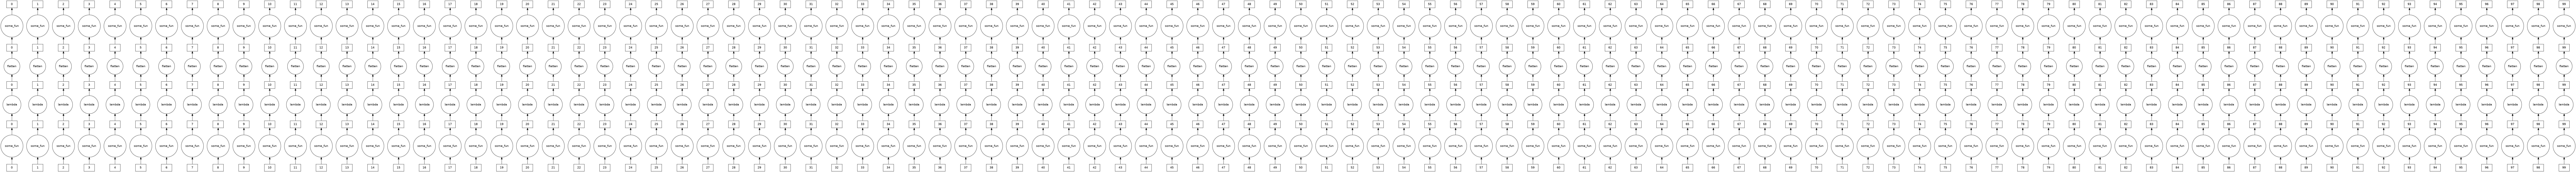

In [4]:
b, queues, (len1, len2) = setup_computation()
b.visualize()

### The common case

In [5]:
result = compute_with_progress(b, *queues)
len(result), sum(result)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

(6000, 13495500)

### Specify length

In [6]:
result = compute_with_progress(b, *queues, desc1=" First map", desc2="Second map", total1=len1, total2=len2)
len(result), sum(result)

 First map:   0%|          | 0/3000 [00:00<?, ?it/s]

Second map:   0%|          | 0/6000 [00:00<?, ?it/s]

(6000, 13495500)

### Use the tqdm-like iterator interface

Here, we monitor only one queue. Note that the other one is still accumulating messages (and could lead to an OOM, so don't really do this for production code...).

In [7]:
from itertools import accumulate
prog = progress(b, queues[1], total=len2)
for total in accumulate(prog):
    prog.set_postfix_str(f'Rows loaded: {total: 12,d}')
result = prog.result()

  0%|          | 0/6000 [00:00<?, ?it/s]

### tqdm-like iterator interface for multiple queues

In [11]:
prog = progress(b, *queues, total1=len1, total2=len2)
totals = { q.name: 0 for q in queues }
for v in prog:
    totals[prog.q.name] += v
    prog.set_postfix_str(f'Rows loaded: {totals[prog.q.name]: 12,d}', refresh=False)
result = prog.result()
len(result), sum(result)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

(6000, 13495500)